In [299]:
from nltk.corpus import stopwords
from nltk import stem
import re
from collections import Counter
import numpy as np
from sklearn.cluster import KMeans
%pylab inline
from textblob import TextBlob
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score,roc_curve
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import ftfy
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from seaborn import lmplot
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Function to get titles of talks

In [302]:
def get_titles_from_talks(talks):
    
    title = []
    # For all the talks in that category
    for talk in talks:
        # if the talk is not empty
        if talk != "":
            # split talk and the header
            h,s = talk.lower().split("\n\n")
            # Header contains the title and the number of views
            t,v = h.split("\n")
            # Get the titles
            title.append(t)
    return title

In [303]:


with open("entertainment.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks= list(set((talks)))
       
ent = get_titles_from_talks(talks)



with open("technology.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
tech = get_titles_from_talks(talks)




with open("science.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
science = get_titles_from_talks(talks)




with open("business.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
business = get_titles_from_talks(talks)




with open("global_issues.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
glob = get_titles_from_talks(talks)





## Getting the talks that occur only once over the whole corpus.

In [304]:
topic_c = Counter()
# loop over all the talk-titles in each of the category
for topic in [ent,tech,glob,business,science]:
    #increment the counter for that title if it occurs more than once
    topic_c += Counter(topic)
# unzip the counter object
topic,c = zip(*topic_c.items())
# select the talks that only occur once
titles = np.array(topic)[np.where(np.array(c)==1)]



### These single letter labels make it easy to unserstand the output in some places

s -> science --- 0

t -> Technology --- 1

b ->business --- 2

g ->global --- 3

e -> entertainment ---4

## Creating a dictionary of labels for all the talks

## These are the actual labels : I'm getting them beacuse I'm loading talks category wise.

In [305]:
d = {}

for title in titles:
    if title in tech:  # Talks in technology  have title "t"
        d[title]="t"
    if title in ent:# Talks in entertainment  have title "e"
        d[title]="e"
    if title in business: # Talks in business  have title "b"
        d[title]="b"
    if title in glob: # Talks in global issues  have title "g"
        d[title]="g"
    if title in science: # Talks in science  have title "s"
        d[title]="s"


## Category sizes/splits :

### business = 123

### entertainment = 152

### global issues = 245

### science = 209

### technology = 249

In [306]:
Counter(d.values())

Counter({'b': 123, 'e': 152, 'g': 245, 's': 209, 't': 249})

----

# we donot have much class imbalance. 

# Base line accuracy is 25-30%

-----

## Adding words to the stop words list, this is formed by doing many Iterations over performance of topic mdeling

In [307]:
stop_w = stopwords.words("english")
stop_w.extend(["say","we're","said","things","becae","jt","it's",'one','like','people','going','know',"that's",'think','see','really',"get","would","i'm","don't","us","actually","may","always","found","fact","lost","you've","end"])
stop_w.extend(["sided","something","thing","got","also","we've","there's","time","well","way","want","could","first","two","new","they're","you're","take","back","need","many","kind","ever","four","five","used","maybe","start"])
stop_w.extend(["go","right","make","look","much","even","little","good","work","lot","put","use","three","come","around","different","another","i'll","ask","took","came","tell","great","find","i've","give","went","called","didn't","talk"])
stop_w.extend(["every","thank","day","big","can't","made","started","still","might","let's","idea","000","what's","years","year","able","start","example","question","show","problem","next","part","let","ago","doesn't","he's","here's","help"])
stop_w.extend(["almost","living","none","we'd","people's","using","says","okay","yet","10","second","i'd","goes","try","point","20","without","getting","happen","anything","else","wheather","true","ok","30","isn't","per","given","others","we'll","wouldn't","size","who's"])
stop_w.extend(["yeah","simple"])

## Loading all the documents together, retaining all the punctuations to get a proper count of pauses and question marks for EDA

In [308]:
#Loading the file that contains all the talks. These belong to all the categories that we have
with open("all.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
views = []
speeches = []
title = []
labels = []
senti = []
talks.remove("")

# loop over talks
for talk in talks:
    

    # Split the header and the actual speech
    h,s = talk.lower().split("\n\n")
    #split the header , that contains title and the views
    t,v = h.split("\n")
    # If that title is predent in the talks that are unique , which we computed earlier
    if t in d:
        # some punctuation removal
        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")

        # removing stop words
        s = " ".join(i for i in s.split() if i not in stop_w)
        
        f = TextBlob(s)
        senti.append(f.polarity)
        
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## Creating labels in terms of numbers is useful, some functions need them .

In [309]:
# Creating a list of labels in terms on numbers

num_label = []
for i in labels:
    if i =="s":
        num_label.append(0)
    if i =="t":
        num_label.append(1)
    if i =="b":
        num_label.append(2)
    if i =="g":
        num_label.append(3)
    if i ==s:
        num_label.append(3)
    if i =="e":
        num_label.append(4)


## Counting functions for EDA

In [310]:
def count_pause(speeches):
    counts = []
    for s in speeches:
        counts.append(s.count("--")+s.count(" --")+s.count("-- "))
    return counts  
def count_questions(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("?")+s.count(" ?")+s.count("? "))
    return counts 
def count_laughters(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(laughter)")+s.count("laughter"))
    return counts 
def count_applause(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(applause)")+s.count("applause"))
    return counts 


In [324]:
views = np.array(views).astype(int)
d_ = {"views":views,"labels":labels,'sentiment':senti,'pause': count_pause(speeches), 'questions': count_questions(speeches),'laughter':count_laughters(speeches),"applause":count_applause(speeches)}
df_eda = pd.DataFrame(data=d_)

## EDA and summary stats:

In [325]:
df_ = df_eda.groupby("labels").sum()
df_

,applause,laughter,pause,questions,sentiment,views
labels,,,,,,
b,465,1094,2466,1859,10.221887,311733541
e,1033,2239,3620,2250,12.952094,299570723
g,1038,1130,5030,2689,12.174506,299169383
s,713,1747,3912,2272,16.393063,358767319
t,1200,1825,4437,2693,23.603602,383874921


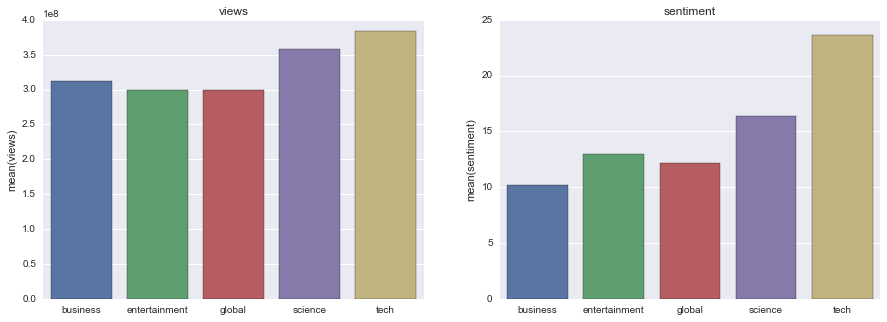

In [326]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.views)
plt.title("views")
plt.subplot(1,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.sentiment)
plt.title("sentiment")

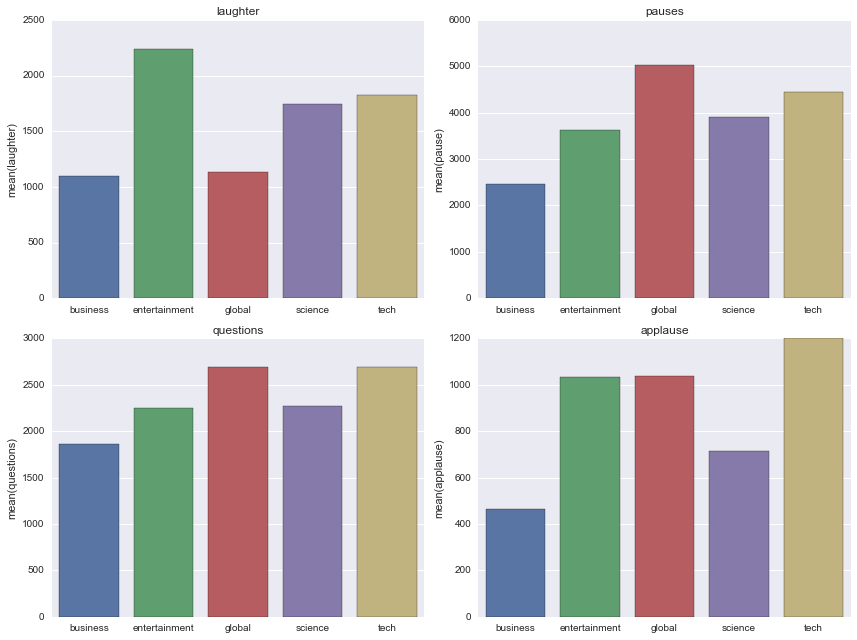

In [327]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.laughter)
plt.title("laughter")
plt.subplot(2,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.pause)
plt.title("pauses")
plt.subplot(2,2,3)
sns.barplot(["business","entertainment","global","science","tech"],df_.questions)
plt.title("questions")
plt.subplot(2,2,4)
sns.barplot(["business","entertainment","global","science","tech"],df_.applause)
plt.title("applause")
plt.tight_layout()

In [328]:
view = np.array(df_eda.views).astype(int)

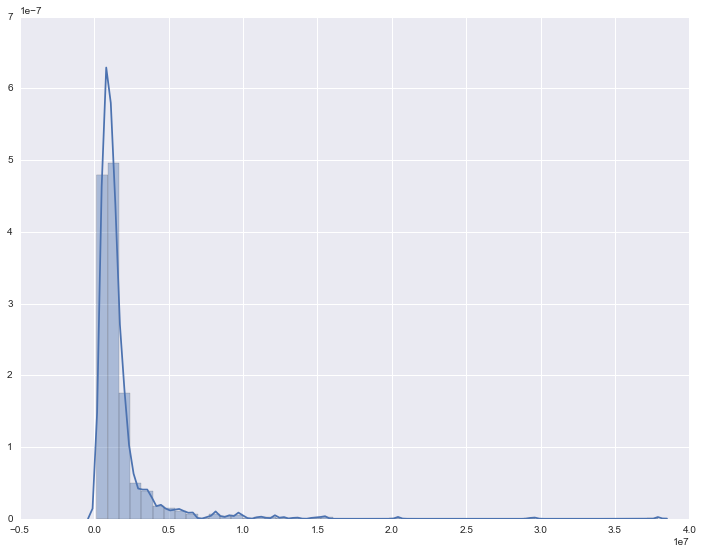

In [329]:
plt.figure(figsize=(12,9))
sns.distplot(view)

## Just trying to understand the features more. 

#### The features we are looking at here are not words, they are:  laughter,  applause, pauses, questions, sentiment

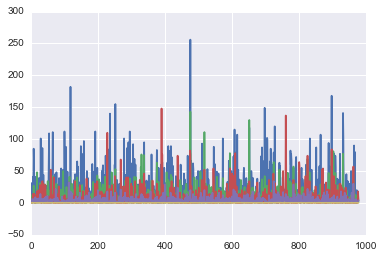

In [330]:
plot(X)

## Load all documents together, with all the preprocessing steps included

## Pre-processing:

1)  encoding

2) punctuation and symbols 

3)stop words removal

4) Lemmatization 

5)POS tagging  retaining NN and NNP


In [290]:
stop_w = stopwords.words("english")
stop_w.extend(["say","we're","said","things","becae","jt","it's",'one','like','people','going','know',"that's",'think','see','really',"get","would","i'm","don't","us","actually","may","always","found","fact","lost","you've","end"])
stop_w.extend(["sided","something","thing","got","also","we've","there's","time","well","way","want","could","first","two","new","they're","you're","take","back","need","many","kind","ever","four","five","used","maybe","start"])
stop_w.extend(["go","right","make","look","much","even","little","good","work","lot","put","use","three","come","around","different","another","i'll","ask","took","came","tell","great","find","i've","give","went","called","didn't","talk"])
stop_w.extend(["every","thank","day","big","can't","made","started","still","might","let's","idea","000","what's","years","year","able","start","example","question","show","problem","next","part","let","ago","doesn't","he's","here's","help"])
stop_w.extend(["almost","living","none","we'd","people's","using","says","okay","yet","10","second","i'd","goes","try","point","20","without","getting","happen","anything","else","wheather","true","ok","30","isn't","per","given","others","we'll","wouldn't","size","who's"])
stop_w.extend(["yeah","simple","laughing","laughter","(laughter)"])

In [291]:
with open("all.txt") as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
views = []
speeches = []
title = []
labels = []
talks.remove("")

for talk in talks:
    


    h,s = talk.lower().split("\n\n")
    
    t,v = h.split("\n")
    
    if t in d:

        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")
        s = s.replace("-- "," ").replace(" --"," ").replace("? "," ").replace("?"," ").replace("  "," ")
        s = re.sub(r"\((.\w+)\)","",s)
        
        #STOP WORDS removal and LEMMATIZING
        
        s = " ".join(lemma.lemmatize(i) for i in s.split() if i not in stop_w)
        
    
        words,tag = zip(*nltk.pos_tag(s.split()))
        # POS tagging 
        index = set(np.where(np.array(tag)=="NN")[0])
        np_index = set(np.where(np.array(tag)=="NNP")[0])
        index = list(index.union(np_index))
 
        words = np.array(words)[index]
        s = " ".join(i for i in words)
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## checking the word counts for better understanding

In [292]:
c = Counter()
#for each speech
for s in speeches:
    # counter for words
    c += Counter(s.split())
from operator import itemgetter
sorted_ = sorted(c.items(),key = itemgetter(1),reverse=True)[:10]
w,c = zip(*sorted_)

## Plotting the word counts 

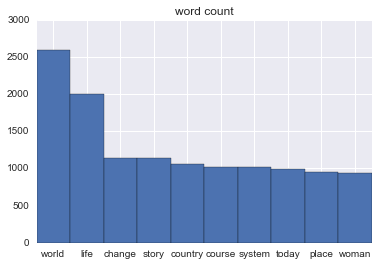

In [293]:
indexes = np.arange(len(w))
width = 1

plt.bar(indexes, c, width)
plt.xticks(indexes + width * 0.5, w)
plt.title("word count")
plt.show()

## Count Vectorizer, Tfidf vectorizer

In [294]:
from sklearn.decomposition.online_lda import LatentDirichletAllocation
df = pd.DataFrame(speeches)
df.columns=["speeches"]
df["labels"]=labels
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# TFIDF VECTORIZER

tfidf_model =TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tfidf = tfidf_model.fit_transform(df.speeches)

#COUNT VECTORIZER

tf_model =CountVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tf = tf_model.fit_transform(df.speeches)


## Visualizing the TFIDF vectors using a manifold similarity between document vectors:

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


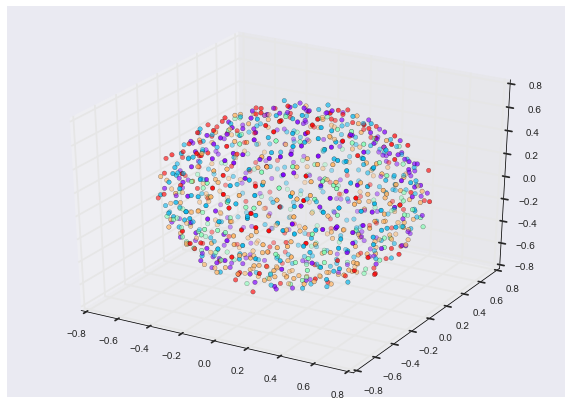

In [72]:
dist = 1 - cosine_similarity(vectorized_tfidf)
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1],pos[:,2]

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(xs,ys,zs,c=num_label,cmap=plt.cm.rainbow)


> Visualizing the similarities among the document vectors. There is no clear pattern , but we will see by the end of the project that the doc2vec document vectors will make more sense. 

## Running LDA  on count vectorized documents. LDA on count vectorized vectors gave better results as compared to LDA on TFIDF.

In [73]:
# build LDA model

lda = LatentDirichletAllocation(n_topics=5,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(vectorized_tf)
topics_words = lda.components_
words = tf_model.get_feature_names()

# Print the words that represent the topics

def print_top_words(model,words,n_top_words=100):
    for index,topic in enumerate(model.components_):
        print("Topic #%d:" % index)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
print("Topics in LDA model:")
tf_feature_names = tf_model.get_feature_names()
print_top_words(lda, tf_feature_names)

Topics in LDA model:
Topic #0:
world country life woman percent change city today school state money government dollar child place power food business family system course story number war kid energy society home job water reason issue community economy value education company health technology democracy leader planet case choice area market space level group month law difference growth history cost organization climate matter car man population side everyone everything news nothing opportunity development call line week service sense picture term rate decade girl mean care nation century bit security crisis order village poverty china pay person bank age word guy income program hand everybody oil
Topic #1:
life world story man word course guy hand book place moment sort water person everything god image language music experience eye love compassion woman call child face feel everybody picture nothing change mind sense friend room mean war bit art somebody mother science night play spa

a,b=zip(*nltk.pos_tag(speeches[2].split()))
index = np.where(np.array(b)=="NN")
list(index).extend(np.where(np.array(b)=="NNP"))
np.array(a)[index]

## How LDA performs compares to the actual labels that we have :

In [261]:
v = lda.transform(vectorized_tf)
Counter([np.argmax(i) for i in v])

Counter({0: 271, 1: 351, 2: 352, 3: 1, 4: 3})

> It doesnt perform that well, we can see that the documents are unevenly distributed among the clusters. But we donot have any class imbalance in our data.

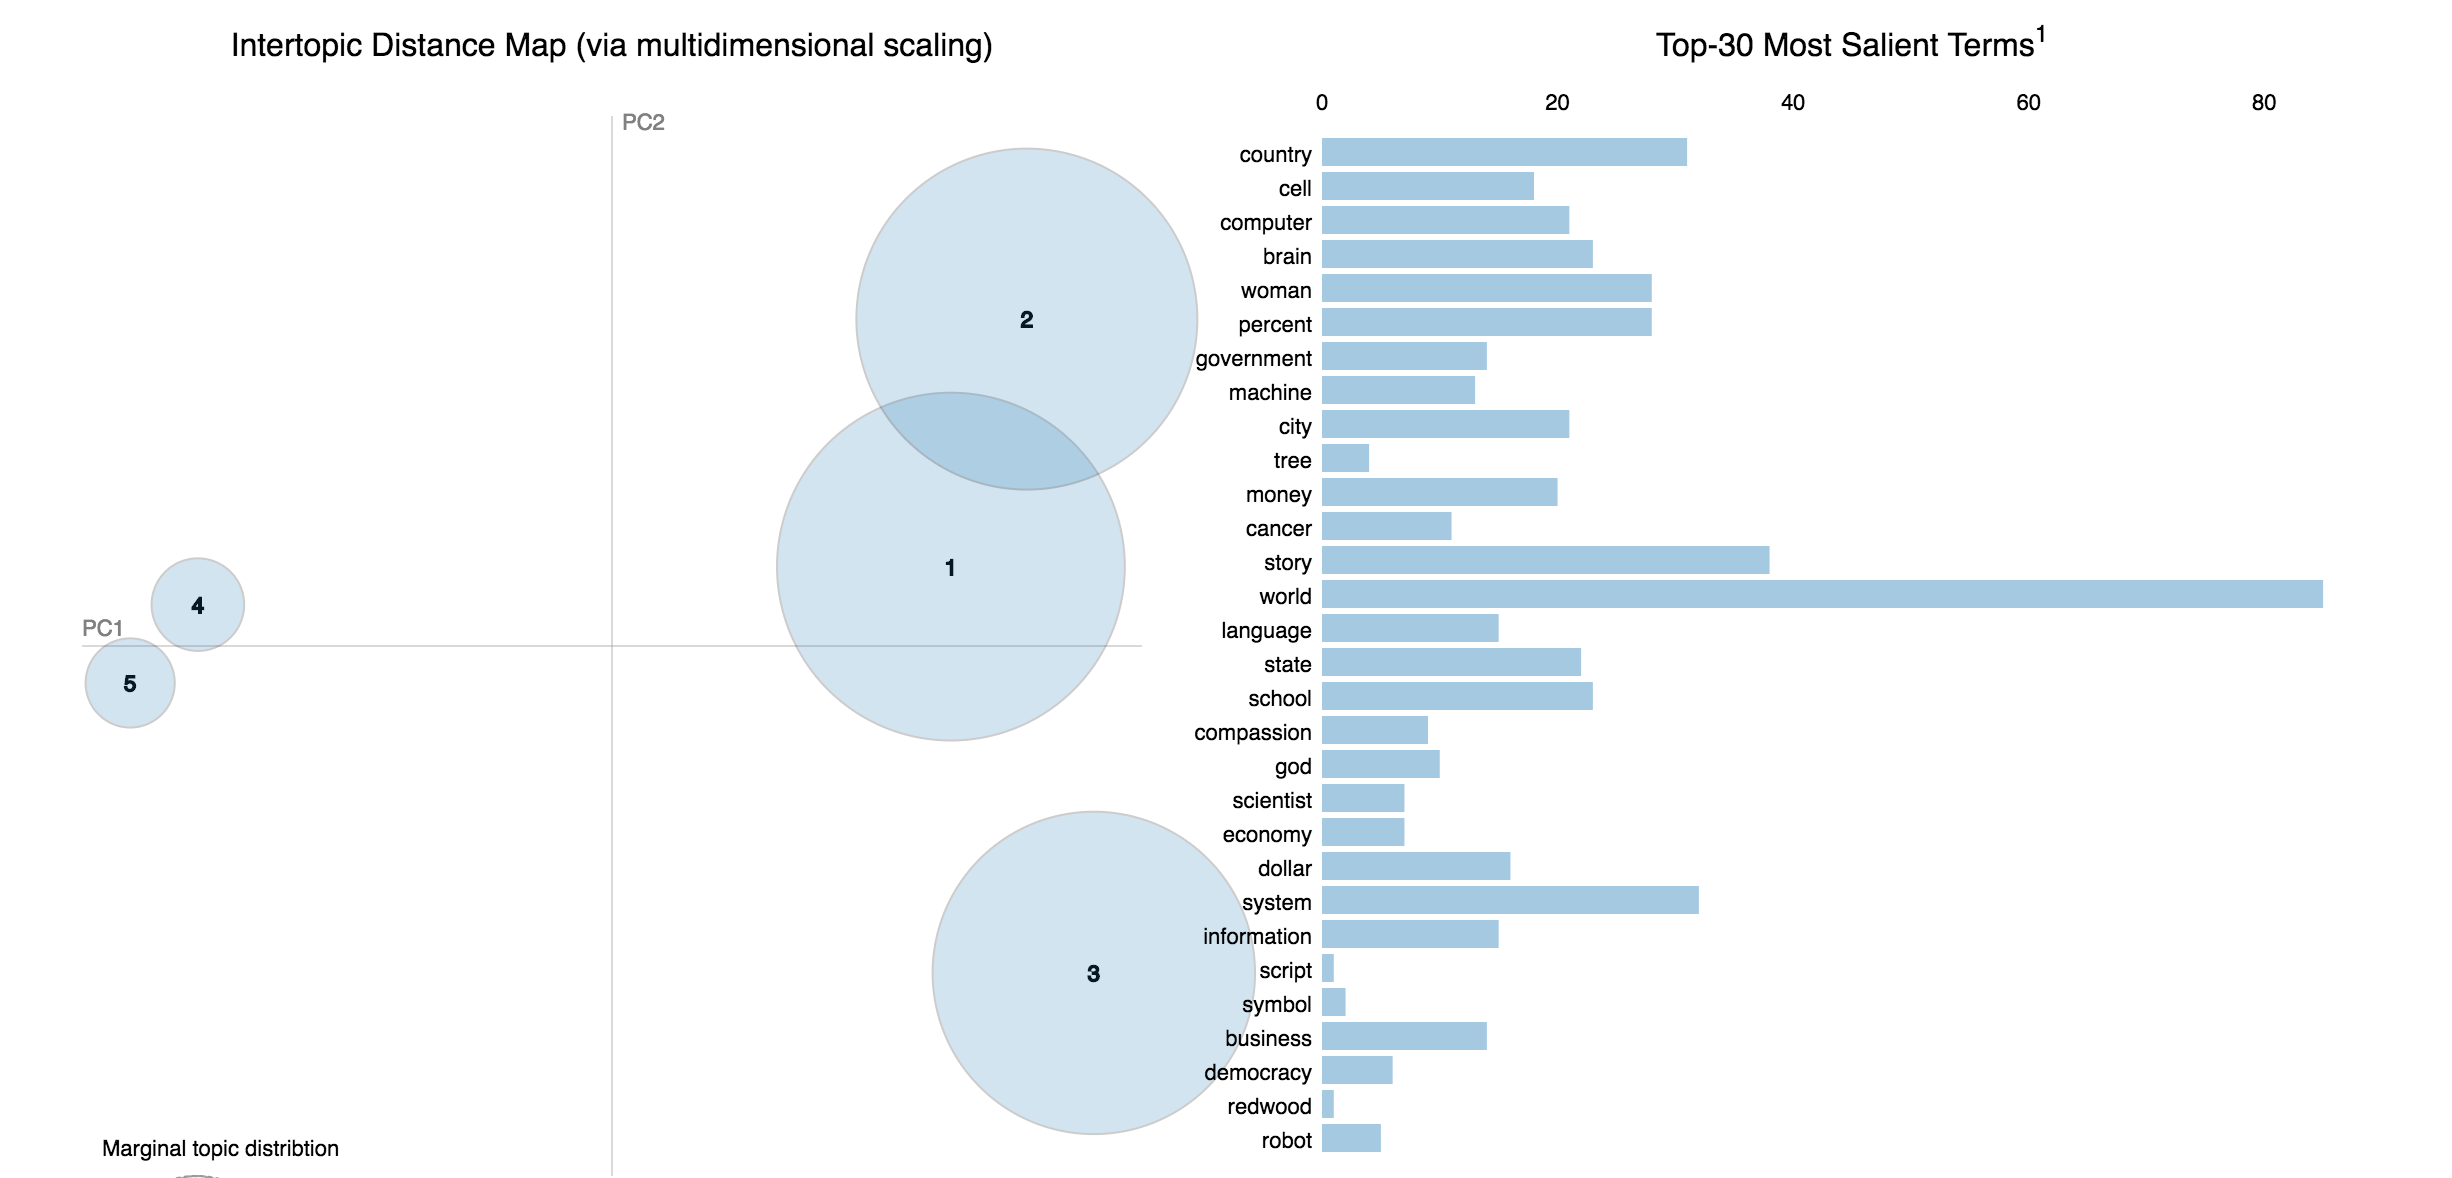

In [298]:
from IPython.display import Image
Image(filename='LDA_clusters.png', width=1000)

In [75]:
pyLDAvis.sklearn.prepare(lda,vectorized_tfidf,tfidf_model)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      33.818737        1       1  0.067666  0.015641
2      32.502396        1       2  0.086629  0.077445
0      29.059806        1       3  0.103350 -0.085816
4       2.396636        1       4 -0.120370  0.006144
3       2.222425        1       5 -0.137275 -0.013413, topic_info=      Category       Freq          Term      Total  loglift  logprob
term                                                                
2407   Default  31.000000       country  31.000000  30.0000  30.0000
1579   Default  18.000000          cell  18.000000  29.0000  29.0000
2119   Default  21.000000      computer  21.000000  28.0000  28.0000
1165   Default  23.000000         brain  23.000000  27.0000  27.0000
11371  Default  28.000000         woman  28.000000  26.0000  26.0000
7533   Default  28.000000       percent  28.000000  25.0000  25.0000
4428   Default  14.000000    government  14.000000  24.0000  24.0000
6171   Default  13.000000       machine  13.000000  23.0000  23.0000
1830   Default  21.000000          city  21.000000  22.0000  22.0000
10764  Default   4.000000          tree   4.000000  21.0000  21.0000
6726   Default  20.000000         money  20.000000  20.0000  20.0000
1422   Default  11.000000        cancer  11.000000  19.0000  19.0000
9861   Default  38.000000         story  38.000000  18.0000  18.0000
11429  Default  85.000000         world  85.000000  17.0000  17.0000
5824   Default  15.000000      language  15.000000  16.0000  16.0000
9785   Default  22.000000         state  22.000000  15.0000  15.0000
9068   Default  23.000000        school  23.000000  14.0000  14.0000
2073   Default   9.000000    compassion   9.000000  13.0000  13.0000
4378   Default  10.000000           god  10.000000  12.0000  12.0000
9083   Default   7.000000     scientist   7.000000  11.0000  11.0000
3344   Default   7.000000       economy   7.000000  10.0000  10.0000
3147   Default  16.000000        dollar  16.000000   9.0000   9.0000
10139  Default  32.000000        system  32.000000   8.0000   8.0000
5246   Default  15.000000   information  15.000000   7.0000   7.0000
9113   Default   1.000000        script   1.000000   6.0000   6.0000
10120  Default   2.000000        symbol   2.000000   5.0000   5.0000
1332   Default  14.000000      business  14.000000   4.0000   4.0000
2786   Default   6.000000     democracy   6.000000   3.0000   3.0000
8488   Default   1.000000       redwood   1.000000   2.0000   2.0000
8828   Default   5.000000         robot   5.000000   1.0000   1.0000
...        ...        ...           ...        ...      ...      ...
7743    Topic5   0.042211       planter   0.125806   2.7145  -8.3911
9545    Topic5   0.039605     socialand   0.118936   2.7069  -8.4549
9643    Topic5   0.041032  spacebecause   0.125148   2.6914  -8.4195
6296    Topic5   0.069966         marie   0.228122   2.6247  -7.8858
8990    Topic5   0.276641    sanitation   1.219076   2.3234  -6.5111
2331    Topic5   0.078846       copepod   0.286140   2.5176  -7.7663
10764   Topic5   0.593576          tree   4.169927   1.8571  -5.7477
7920    Topic5   0.082693          pour   0.323334   2.4430  -7.7187
8340    Topic5   0.135576    rainforest   0.724916   2.1300  -7.2243
6645    Topic5   0.075525   mississippi   0.301775   2.4213  -7.8094
7181    Topic5   0.245120      organism   2.576802   1.4540  -6.6321
7638    Topic5   0.063947        photon   0.291864   2.2883  -7.9758
8796    Topic5   0.062343        ripple   0.325654   2.1534  -8.0012
1916    Topic5   0.116503         coast   2.270355   0.8368  -7.3759
8027    Topic5   0.076422       primate   0.630330   1.6966  -7.7976
10609   Topic5   0.109004        toilet   1.932543   0.9314  -7.4424
5788    Topic5   0.084520            la   0.901993   1.4390  -7.6968
11429   Topic5   0.204569         world  85.551251  -2.2294  -6.8129
5985    Topic5   0.169150          life  66.766110  -2.1716 

## NMF - Topic Modeling using TFIDF 

In [76]:
from sklearn.decomposition import NMF

In [77]:
#Build te NMF Model

nmf = NMF(init="nndsvd",
            n_components=5,
            max_iter=200)
nmf.fit(vectorized_tfidf)
topics_words = nmf.components_
words = tfidf_model.get_feature_names()

print("Topics in NMF model:")
tf_feature_names = tfidf_model.get_feature_names()
print_top_words(nmf, tf_feature_names)

Topics in NMF model:
Topic #0:
woman country world life story school family child war compassion man money girl mother society state government job business leader god peace democracy community kid percent health home son face violence today education change care death village parent father person friend power month daughter religion love law prison book nothing word issue moment voice dollar name guy dream aid week everybody feel refugee baby group place college news course film brother boy room organization value age everything student side doctor sex poverty difference role rule leadership victim house hand culture history reason somebody election husband eye income someone medium number
Topic #1:
computer machine technology sort design robot information project phone car image video space system language guy world device internet person book picture science word page game student number course bit hand stuff camera google kid art web company eye paper everything play room shape too

## Manual labelling of the topics

0 --> business

1 --> technology

2 --> global

3 -->science

4 ---> entertainment


## Checking performance of Topic Modeling

In [79]:
v = nmf.transform(vectorized_tfidf)

Counter([np.argmax(i) for i in v])

Counter({0: 214, 1: 318, 2: 243, 3: 133, 4: 70})

> We can see that the documents are almost equally distributed over all the categories, which is how our initial data was divided into categories

### Manually labelling the topics 

In [82]:
p = []
for i in [np.argmax(i) for i in v]:
    if i ==0:
        p.append("g") # global issues
    if i ==1:
        p.append("t") # tech
    if i ==2:
        p.append("b") # business
    if i ==3:
        p.append("s") # science
    if i ==4:
        p.append("e") # entertainment


# Very important ***  

# Make sure you label the topics manually every time you re-run NMF.  

# NMF assigns random numbers to the topics that it prints. So read the words , label the topics using the previous cell. That is ->   p....    and then check for accuracy

## I'm checking  for accuracy after doing the labeling 

In [83]:
print("accuracy of my topic modeling : ",np.round(accuracy_score(labels,p)*100),"%")

accuracy of my topic modeling :  45.0 %


## I'm getting an accuracy of 45% which is better than most of the classifiers that I tried on the tfidf matrix.


## Visualizing the NMF model: There is a clear seperation between the topics, and they all make perfect sense when we examine the words in each topic.

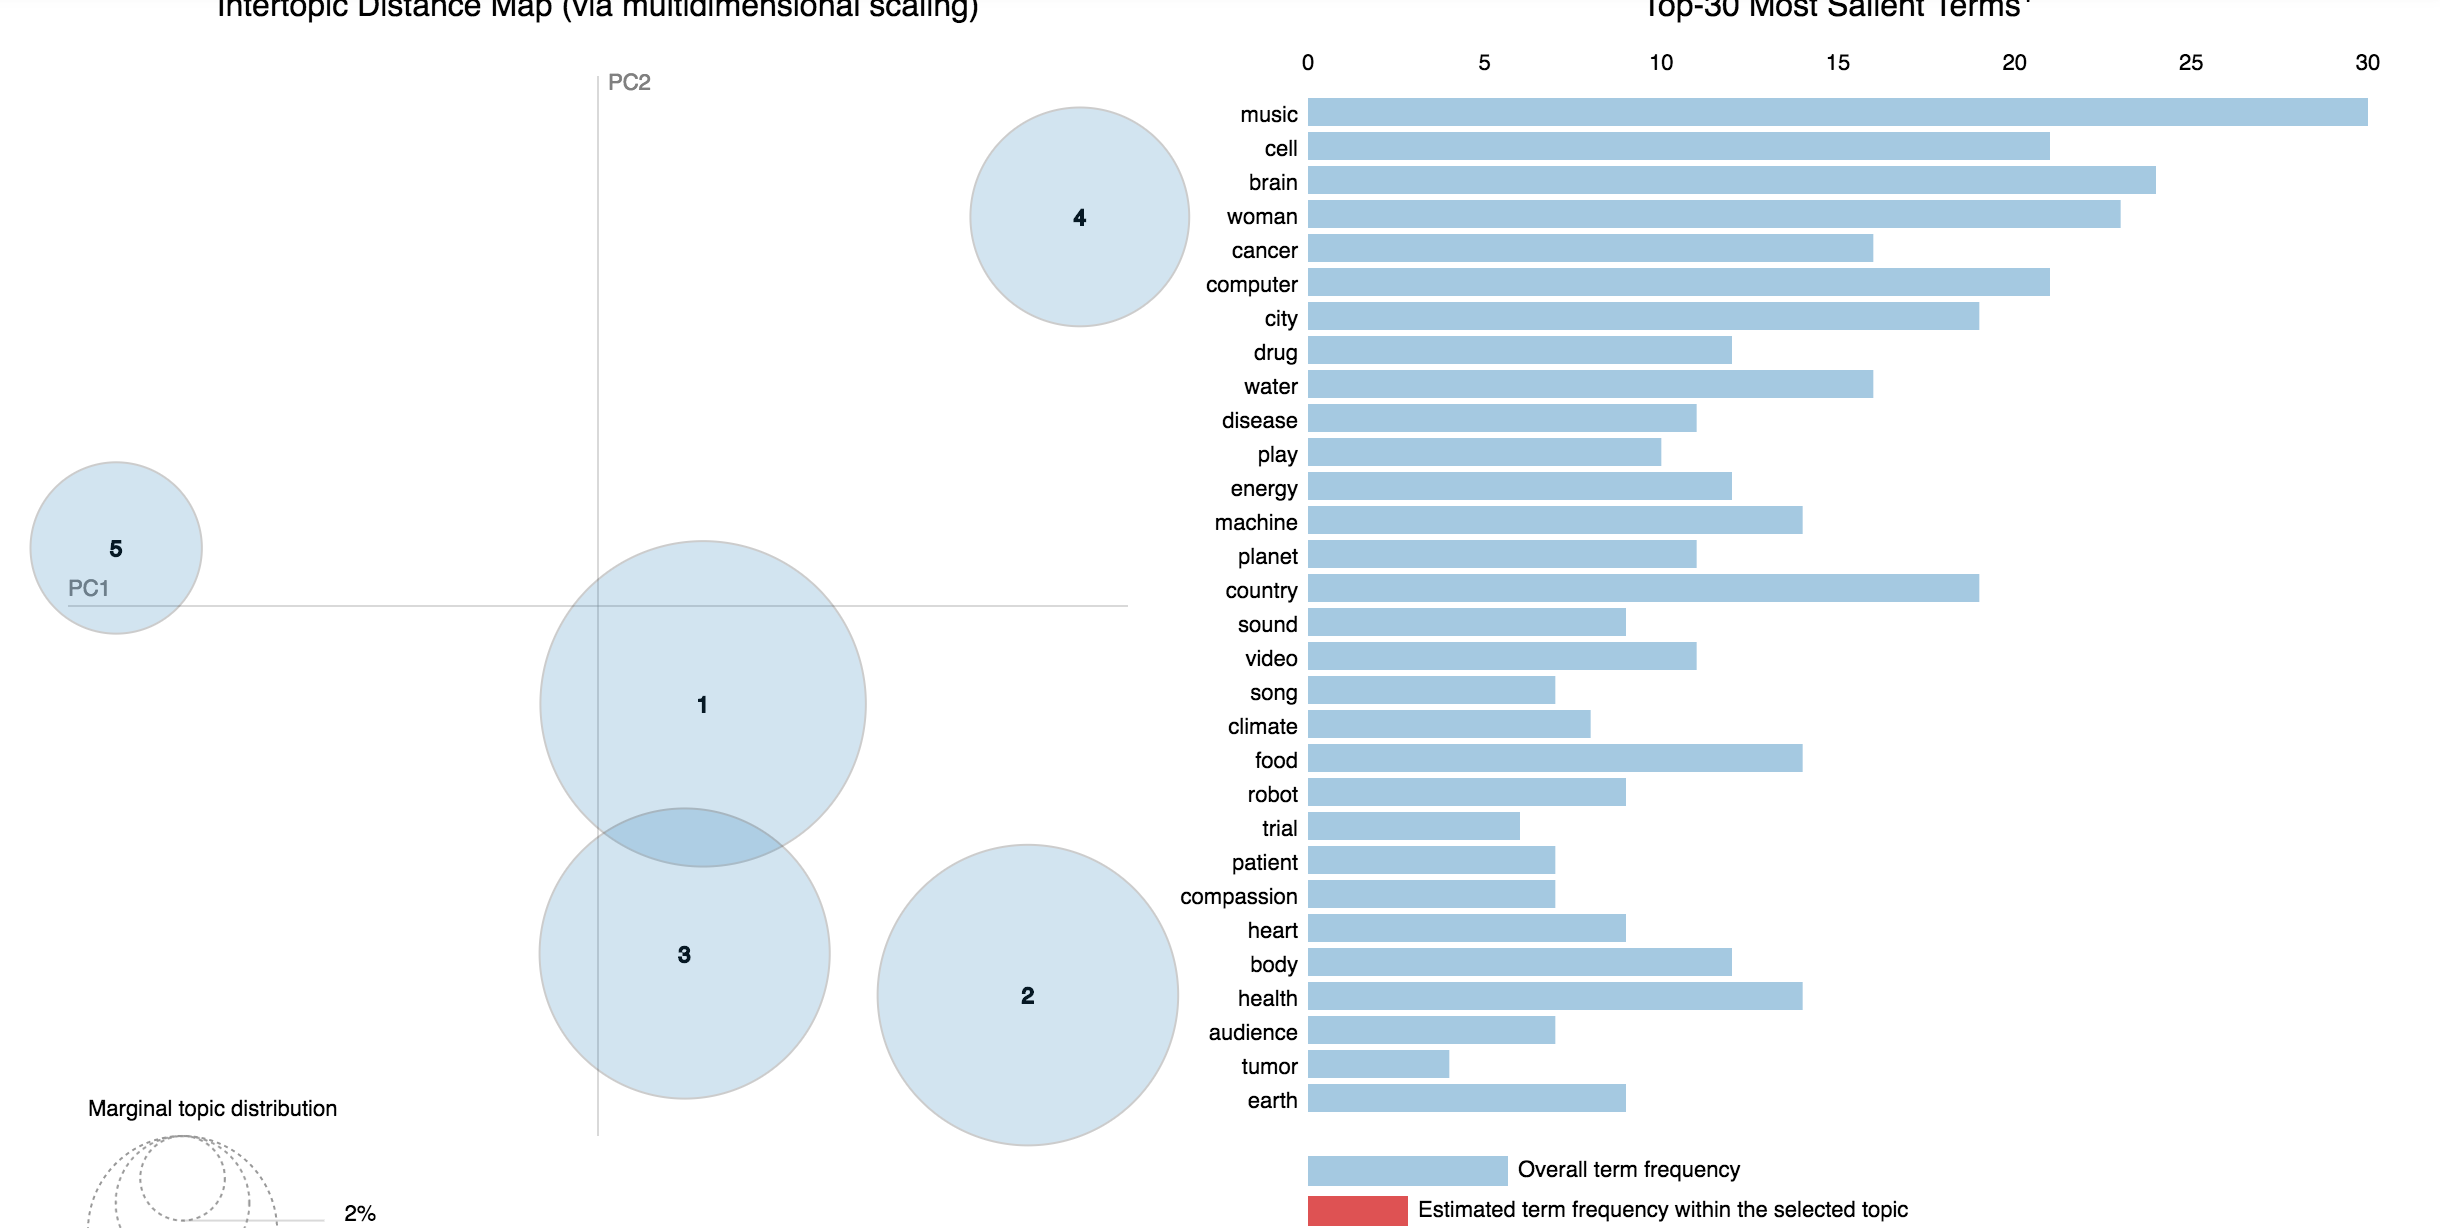

In [296]:
from IPython.display import Image
Image(filename='NMF_clusters.png', width=1000)

In [84]:
pyLDAvis.sklearn.prepare(nmf,vectorized_tfidf,tfidf_model)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      29.610128        1       1 -0.008209 -0.008707
2      25.258432        1       2  0.130577 -0.133172
0      23.538109        1       3 -0.016102 -0.115405
3      13.384854        1       4  0.152763  0.199381
4       8.208476        1       5 -0.259029  0.057903, topic_info=      Category       Freq        Term      Total  loglift  logprob
term                                                              
6862   Default  30.000000       music  30.000000  30.0000  30.0000
1579   Default  21.000000        cell  21.000000  29.0000  29.0000
1165   Default  24.000000       brain  24.000000  28.0000  28.0000
11371  Default  23.000000       woman  23.000000  27.0000  27.0000
1422   Default  16.000000      cancer  16.000000  26.0000  26.0000
2119   Default  21.000000    computer  21.000000  25.0000  25.0000
1830   Default  19.000000        city  19.000000  24.0000  24.0000
3270   Default  12.000000        drug  12.000000  23.0000  23.0000
11197  Default  16.000000       water  16.000000  22.0000  22.0000
3033   Default  11.000000     disease  11.000000  21.0000  21.0000
7758   Default  10.000000        play  10.000000  20.0000  20.0000
3484   Default  12.000000      energy  12.000000  19.0000  19.0000
6171   Default  14.000000     machine  14.000000  18.0000  18.0000
7727   Default  11.000000      planet  11.000000  17.0000  17.0000
2407   Default  19.000000     country  19.000000  16.0000  16.0000
9621   Default   9.000000       sound   9.000000  15.0000  15.0000
11041  Default  11.000000       video  11.000000  14.0000  14.0000
9609   Default   7.000000        song   7.000000  13.0000  13.0000
1874   Default   8.000000     climate   8.000000  12.0000  12.0000
4037   Default  14.000000        food  14.000000  11.0000  11.0000
8828   Default   9.000000       robot   9.000000  10.0000  10.0000
10777  Default   6.000000       trial   6.000000   9.0000   9.0000
7423   Default   7.000000     patient   7.000000   8.0000   8.0000
2073   Default   7.000000  compassion   7.000000   7.0000   7.0000
4739   Default   9.000000       heart   9.000000   6.0000   6.0000
1072   Default  12.000000        body  12.000000   5.0000   5.0000
4728   Default  14.000000      health  14.000000   4.0000   4.0000
588    Default   7.000000    audience   7.000000   3.0000   3.0000
10835  Default   4.000000       tumor   4.000000   2.0000   2.0000
3318   Default   9.000000       earth   9.000000   1.0000   1.0000
...        ...        ...         ...        ...      ...      ...
2135    Topic5   2.086223     concert   2.210610   2.4421  -5.7973
6822    Topic5   1.048554      mozart   1.085607   2.4653  -6.4852
3275    Topic5   1.952683        drum   2.140497   2.4082  -5.8634
7652    Topic5   0.717290     pianist   0.741984   2.4662  -6.8649
4722    Topic5   1.043105   headphone   1.122989   2.4262  -6.4904
10124   Topic5   1.630343    symphony   1.939483   2.3264  -6.0438
9609    Topic5   4.912569        song   7.067389   2.1363  -4.9408
1450    Topic5   1.337868        cape   1.554474   2.3499  -6.2416
9621    Topic5   5.505942       sound   9.667064   1.9371  -4.8268
7653    Topic5   1.838059       piano   2.421840   2.2242  -5.9239
7758    Topic5   5.873641        play  10.920436   1.8798  -4.7622
4590    Topic5   1.754294        hall   2.413362   2.1810  -5.9706
5811    Topic5   1.237582        lamb   1.520713   2.2940  -6.3195
588     Topic5   3.772806    audience   7.115807   1.8655  -5.2048
10628   Topic5   1.547428        tone   2.089008   2.1999  -6.0960
7016    Topic5   2.073475        note   3.522948   1.9699  -5.8034
3480    Topic5   1.627166        ends   2.401342   2.1108  -6.0458
2607    Topic5   2.493493       dance   5.125988   1.7794  -5.6189
7667    Topic5   3.232846       piece   9.484348   1.4237  -5.3593
11041   Topic5   3.387310       video  11.182452   1.3057  -5.3126
6994    Topic5   1.784138   

## Kmeans on the reduced dimensions (W matrix of NMF,  NMF->  A= W*H)  of these document vectors

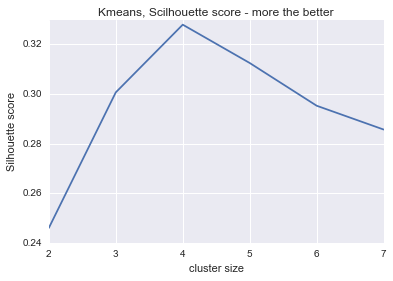

In [86]:
s=[]
for i in range(2,8):
    km = KMeans(n_clusters=i)
    km.fit(v)
    p=km.predict(v)
    s.append(silhouette_score(v,p))
    
plt.plot(range(2,8),s)
plt.title("Kmeans, Scilhouette score - more the better")
plt.xlabel("cluster size")
plt.ylabel("Silhouette score")

> Silhouette score tells us that the best cluster size is 4. But we need 5 clusters. So lets approximate to that!!

## Tuning Parameters for SVM classifier

In [88]:
X_train,X_test, y_train,y_test = train_test_split(vectorized_tfidf,labels,random_state=42)

#### Default SVM parameters: 

In [89]:
svc = SVC()
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
accuracy_score(y_test,y_pred)

0.24489795918367346

### Grid search

In [91]:
svc_grid_var = {'C':[1,10,100,500],
              'gamma':[1,10,100],
              "kernel":["rbf","poly","sigmoid","linear"]}

svc_gridsearch = GridSearchCV(SVC(),svc_grid_var,verbose=True,scoring="accuracy")

best_model_svc = svc_gridsearch.fit(vectorized_tfidf,labels)


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   51.1s
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.4min finished


### Fitting best svm model

In [93]:
best_model_svc.best_estimator_

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
best_model_svc.best_estimator_.fit(X_train,y_train)
y_pred = best_model_svc.predict(X_test)

In [96]:
accuracy_score(y_test,y_pred)

0.72244897959183674

In [97]:
print("SVM accuracy :",accuracy_score(y_test,y_pred)*100,"%")

SVM accuracy : 72.2448979592 %


## Confusion Matrix SVM 

In [98]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,10,3,7,2,6
entertain,1,25,3,3,5
global,3,1,45,1,10
science,1,3,2,43,5
tech,0,1,5,6,54


## ROC -- SVM

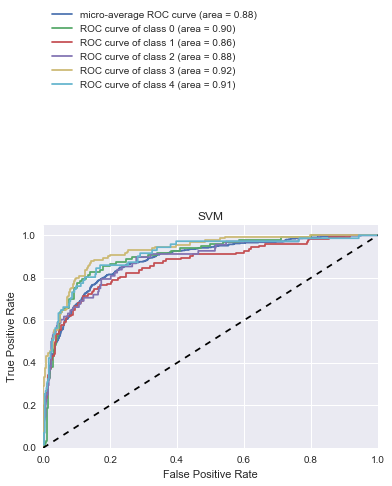

In [100]:
# sklearn code

y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
cv = TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)
cv.fit(X_train)
X_train,X_test = cv.transform(X_train),cv.transform(X_test)
classifier = OneVsRestClassifier(best_model_svc.estimator)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)
#y_score[:,0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("SVM")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

## Random forest 

##  Choosing the default random forest parameters. I changed only number of trees.

In [101]:

X_train,X_test,y_train,y_test = train_test_split(vectorized_tfidf,labels,random_state=52)
RF = RandomForestClassifier(n_estimators=2000)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)


In [102]:
print("Random Forest Accuracy :",accuracy_score(y_test,y_pred))

Random Forest Accuracy : 0.632653061224


## Grid search on Random forest

In [200]:

X_train,X_test,y_train,y_test = train_test_split(vectorized_tfidf,num_label,random_state=52)

In [199]:

rf_grid_var = {'n_estimators':[2000],
              "max_depth":[3,4,5]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),rf_grid_var,verbose=True,scoring="mean_squared_error")

best_model = rf_gridsearch.fit(vectorized_tfidf,num_label)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   33.5s finished


In [201]:
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
accuracy_score(y_test,y_pred)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   30.4s finished


0.51020408163265307

### Confusion Matrix

In [103]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,5,2,8,1,14
entertain,0,26,4,2,6
global,0,10,48,2,7
science,0,2,5,33,8
tech,0,6,6,7,43


## Plotting the ROC curve


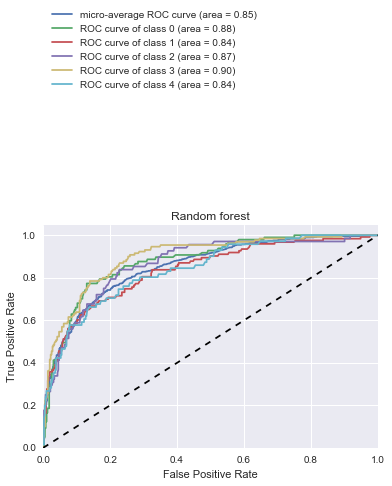

In [104]:

def plot_roc(clf,name):
    y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
    cv = TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)
    cv.fit(X_train)
    X_train,X_test = cv.transform(X_train),cv.transform(X_test)
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
    #y_score[:,0]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
    plt.show()
plot_roc(RandomForestClassifier(n_estimators=2000),"Random forest")

## KNN

### Parameter tuning for knn

In [119]:
X_train,X_test,y_train,y_test = train_test_split(vectorized_tfidf,labels,random_state=52)
score_test =[]
score_train = []
for n in range(1,30):
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_train,y_train)
    p_train = KNN.predict(X_train)
    p_test = KNN.predict(X_test)
    score_train.append(accuracy_score(y_train,p_train))
    score_test.append(accuracy_score(y_test,p_test))

### Finding best K

best k size : 29


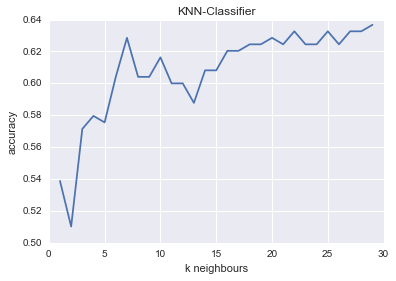

In [106]:
plt.plot(range(1,30),score_test,label = "Test")
plt.xlabel("k neighbours")
plt.ylabel("accuracy")
plt.title("KNN-Classifier")
print("best k size :",range(1,30)[np.argmax(score_test)])
best_k = range(1,30)[np.argmax(score_test)];

## Train and Test vs Model complexity : 

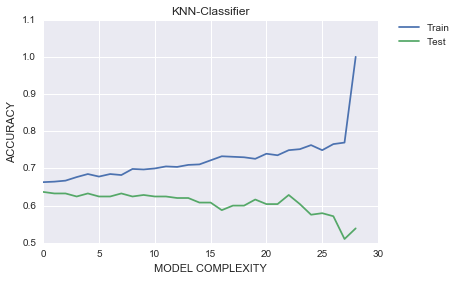

In [107]:
plt.plot(score_train[::-1],label = "Train")
plt.plot(score_test[::-1],label = "Test")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("MODEL COMPLEXITY")
plt.ylabel("ACCURACY")
plt.title("KNN-Classifier");

### Running the best model

In [110]:
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)
print("Accuracy KNN: ",accuracy_score(y_test,y_pred)*100)

Accuracy KNN:  63.6734693878


In [111]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,12,3,8,1,6
entertain,0,20,4,6,8
global,3,0,55,3,6
science,1,0,12,26,9
tech,0,1,9,9,43


## ROC KNN : 

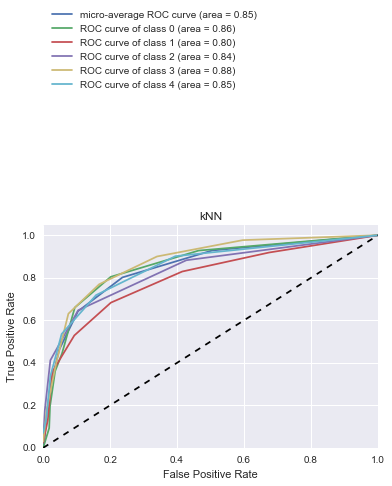

In [112]:
plot_roc(KNeighborsClassifier(n_neighbors=7),"kNN")

## Gradient Boosting

In [120]:
GB = GradientBoostingClassifier(n_estimators=300)
GB.fit(X_train,y_train)
p = GB.predict(X_test.toarray())
accuracy_score(y_test,p)

0.56734693877551023

## Confusion Matrix :

In [121]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,12,3,8,1,6
entertain,0,20,4,6,8
global,3,0,55,3,6
science,1,0,12,26,9
tech,0,1,9,9,43


## LDA does not perform well :

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(vectorized_tfidf, labels, test_size=.5,random_state=0)
s = []
for n in range(2,10):
    linear_da = LinearDiscriminantAnalysis(n_components=n)
    linear_da.fit(X_train.toarray(),y_train)
    p = linear_da.predict(X_test)
    s.append(accuracy_score(y_test,p))

In [132]:
max(s)

0.3279581153747711

## Default LDA

In [133]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(vectorized_tfidf, labels, test_size=.5,random_state=0)
lda_ =  LinearDiscriminantAnalysis()
lda_.fit(X_train.toarray(),y_train)
y_pred = lda_.predict(X_test)
accuracy_score(y_test,y_pred)


//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.49079754601226994

In [134]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,3,5,33,5,22
entertain,1,19,20,9,22
global,0,6,91,13,20
science,1,3,11,54,28
tech,2,9,15,24,73


## ROC :

//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
//anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


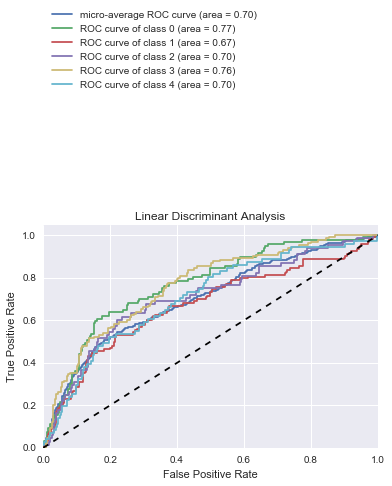

In [136]:
y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
cv = CountVectorizer()
cv.fit(X_train)
X_train,X_test = cv.transform(X_train),cv.transform(X_test)
classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
y_score = classifier.fit(X_train.toarray(), y_train).predict_proba(X_test)
#y_score[:,0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Linear Discriminant Analysis")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

## Doc2vec

In [137]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec


//anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [138]:
def Labeled(s,l):
    sentences = []
    for i,talk in enumerate(s):
        sentences.append(LabeledSentence(utils.to_unicode(talk).split(),[l[i]]))
    return sentences


In [139]:

X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=42)

In [140]:
score = []

## Checking model performance for single epoch training.

### having a hold-out set before sending the data into Doc2Vec model.

In [198]:


X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=2)

sentences = Labeled(X_train,y_train)

model_split = Doc2Vec(min_count=1, window=10, size=128, sample=1e-4, negative=5, workers=7)

model_split.build_vocab(sentences)

model_split.train(sentences)


X_seen = []
for doc_id in range(len(sentences)):
    inferred_vector = model_split.infer_vector(sentences[doc_id].words)
    X_seen.append(inferred_vector)


unseen = []
test_ = []
for doc_id in range(len(X_test)):
    inferred_vector = model_split.infer_vector(X_test[doc_id].split())
    unseen.append(inferred_vector)
    d = dict(model_split.docvecs.most_similar([inferred_vector],topn=len(model_split.docvecs)))
    maxkey_test = max(d, key=lambda y: abs(d[y]))
    test_.append(maxkey_test)

sum(test_==y_test)

116

In [162]:
116/len(y_test)


0.5918367346938775

## Training over multiple epochs :

In [229]:
X_train, X_test, y_train,y_test = train_test_split(np.array(df.speeches),np.array(df["labels"]),train_size=0.8,random_state=2)

In [150]:
for epoch in range(10):
    
    model_split.train(sentences)
    model_split.alpha -=0.02


In [204]:
model_split.most_similar("computer")

[('machine', 0.8952854871749878),
 ('software', 0.8892062306404114),
 ('design', 0.8576284646987915),
 ('device', 0.8553940057754517),
 ('monitor', 0.8490395545959473),
 ('building', 0.8460160493850708),
 ('version', 0.839483916759491),
 ('screen', 0.8357470631599426),
 ('video', 0.8334006071090698),
 ('board', 0.8266938924789429)]

In [152]:

X_seen = []
# loop over the length of documents/sentences
for doc_id in range(len(sentences)):
    # infer the vector for each of the doc
    inferred_vector = model_split.infer_vector(sentences[doc_id].words)
    # append to the empty list
    X_seen.append(inferred_vector)


In [219]:
unseen = []
test_ = []


# Loop over the length of unseen data
for doc_id in range(len(X_test)):
    #infer the vector for each of the unseen document
    inferred_vector = model_split.infer_vector(X_test[doc_id].split())
    # Add that to our empty list
    unseen.append(inferred_vector)
    

## Random Forest on Doc2Vec

In [230]:
RF = RandomForestClassifier(n_estimators=3000)
RF.fit(X_seen,y_train)
p = RF.predict(unseen)
accuracy_score(y_test,p)

0.5714285714285714

In [231]:
print("accuracy Random Forest :",accuracy_score(y_test,p))

accuracy Random Forest : 0.571428571429


## KNN on Doc2Vec

In [223]:
score = []
for n in range(2,30):
    KNN = KNeighborsClassifier(n_neighbors=n)
    KNN.fit(X_seen,y_train)
    p = KNN.predict(unseen)
    score.append(accuracy_score(y_test,p))
    #print("Accuracy KNN: ",accuracy_score(y_test,p)*100)

In [227]:
best_k = range(2,30)[argmax(score)]
print("best k value:",best_k)

best k value: 4


In [228]:
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(X_seen,y_train)
p = KNN.predict(unseen)

print("Accuracy KNN: ",accuracy_score(y_test,p)*100)

Accuracy KNN:  56.6326530612


## Modeling Doc2Vec on the whole data for  Search  ( Information Retrevial)

### We can infer vectors for any keywords from this model. We then compare this vector with all the document vectors to find the highest cosine similarity.

In [234]:
sentences_all = Labeled(df.speeches,df["labels"])

model = Doc2Vec(min_count=1, window=10, size=128, sample=1e-4, negative=5, workers=7)

model.build_vocab(sentences_all)

model.train(sentences)


X = []
for doc_id in range(len(sentences_all)):
    inferred_vector = model.infer_vector(sentences_all[doc_id].words)
    X.append(inferred_vector)


## Kmeans on Doc2Vec document vectors

In [88]:
s = []
for i in range(2,30):
    km = KMeans(n_clusters=i)
    km.fit(X)
    p = km.predict(X)
    s.append(silhouette_score(X,p))

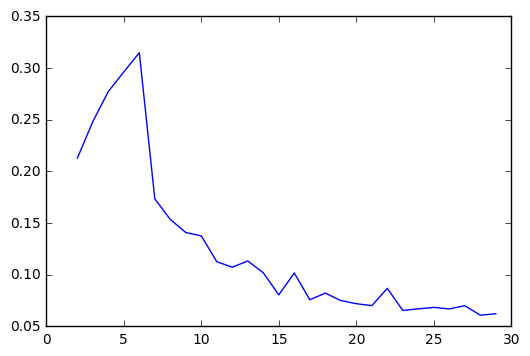

In [913]:
plot(range(2,30),s)

In [635]:
range(2,30)[np.argmax(s)]

5

> We can see that the best cluster size is 5.


In [895]:
X=np.array(X)

In [171]:
label = np.array(df["labels"])
for i,j in enumerate(["t","e","b","g","s"]):
    label[np.where(np.array(df["labels"])==j)]=i

## Visualizing Doc2Vec  Document vectors using TSNE

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


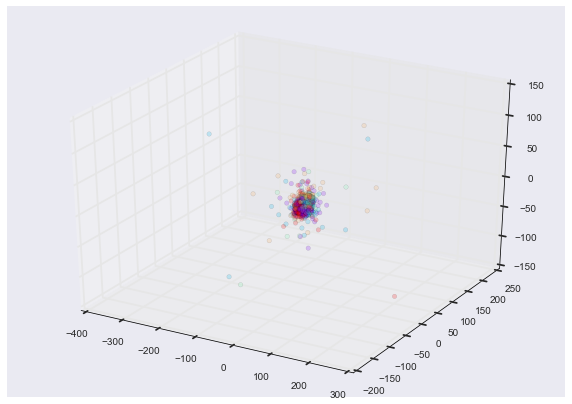

In [172]:
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



tsne = TSNE(n_components=5)
new_x = tsne.fit_transform(X)

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(new_x.T[0],new_x.T[1],new_x.T[2],c=label,alpha=0.2,cmap=plt.cm.rainbow)

## Visualizing Doc2Vec document vectors using the MSD , which is  a manifold similarity based plot.

## We did this on tfidf doc vectors and noticed that there is no proper cluster indication.

## We can see the clusters clearly here

In [174]:

dist = 1 - cosine_similarity(X)


MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1],pos[:,2]



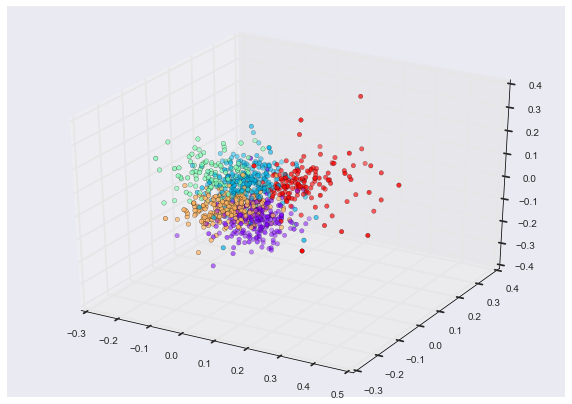

In [177]:

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(xs,ys,zs,c=num_label,cmap=plt.cm.rainbow)

## Search

## We are giving "computer"  as  a search keyword. 

## Infer the vector for "computer" and compare it with all other doc vevtors

In [235]:
X=  np.array(X)
vec = model.infer_vector("computer".split())
t=np.array(labels)[argsort((X.dot(vec)))[::-1]]

In [256]:
t[:10]

array(['t', 't', 't', 't', 't', 't', 't', 't', 't', 't'], 
      dtype='<U1')

> t --> technology

> We can see the top 10 results  and almost all the inital results are technology related. our search was "computer"

## LSA

## I'll be printing the categories of the retreived documents  because its hard to judge the output using the title.

In [265]:

v = []

query = "computer"

svd = TruncatedSVD(n_components=700)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(vectorized_tfidf)

X_dense = svd.inverse_transform(X)


query = "".join(char for char in query.lower() if char not in punctuation).split()

vocab = tfidf_model.get_feature_names()

query=np.array([1 if q in q else 0 for q in vocab])

if np.count_nonzero(query==1)==0:
    print("Keywords don't match with documents")
else:
    score = query.dot(X_dense.T)
    sort = sorted(zip(range(1,len(score)+1),score),key=lambda x:x[1],reverse=True)

    for i in range(len(sort[:10])):
        print((labels)[sort[i][0]])



s
b
b
b
e
g
s
g
t
s


Doc2Vec performs better than LSA. That's because the LSA model doesnt consider the best low-rank approximation of the oriiginal TFIDF matrix.

We can check how good the approximation is by computing Frobenius index. I did not have enough time to tune the LSA model. I was more focused on understanding Doc2Vec.

I had implemented LSA from scratch on the 20 news groups data, for which I computed the frobenius indx and tuned it. You can look at my other project repos on github to find it.

----------------------

# Just a fun thing  that I wanted to try

## Trying to predict number of views using number of pauses, laughters, applauses, sentiment :

In [283]:

X = df_eda[["pause","questions","laughter","applause","sentiment"]].values
y = np.array(df_eda.views)

model = sm.OLS(y.astype(int), X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     99.06
Date:                Fri, 16 Dec 2016   Prob (F-statistic):           1.83e-84
Time:                        14:48:35   Log-Likelihood:                -15744.
No. Observations:                 978   AIC:                         3.150e+04
Df Residuals:                     973   BIC:                         3.152e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4426.8754   3089.948     -1.433      0.152   -1.05e+04    1636.854
x2          1.404e+04   6512.143      2.157      0.031    1264.182    2.68e+04
x3           3.27e+04   6511.696      5.021      0.000    1.99e+04    4.55e+04
x4          1.569e+05   1.77e+04      8.861      0.000    1.22e+05    1.92e+05
x5          3.308e+06   7.94e+05      4.165      0.000    1.75e+06    4.87e+06
==============================================================================
Omnibus:                     1277.403   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291229.961
Skew:                           6.737   Prob(JB):                         0.00
Kurtosis:                      86.458   Cond. No.                         390.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Since we are able to explain only 34% of the variance. we cant use this to predict the views.

# Accuracy on TFIDF :

### SVM = 72%

### Random forest = 63%

### knn = 64%

### gradient boosting = 54%

### LDA =  49 %

# Accuracy on Doc2Vec document vectors :

### Random Forest = 57%

### Knn = 56.6%





# SVM Classifier gave me the best performance:

